# SIT384 TASK 10.2HD: Credit Card Fraud Detection
Visal Dam, s223058093

### Introduction

This task involved training and testing classification and performance-boosting models, based on the given case study and methods presented by by Simon Delarue (2021), to detect whether a payment record is credit card fraud given a set of anonymized features. With the exception of the 'Time' and 'Amount', the features V1 to V28 seemed to be reduced to a normalized state. The models trained and tested were: Support Vector Machines (Stochastic Gradient Descent (SGD) and Support Vector Classifier (SVC)), Extreme Gradient Boosting (XGBooster), Light Gradient Boosting Machine (LightGBM), CatBoost and Random Forest Classification. I also used the stacking approach as implemmented in the case study, though this was done just out of curiosity as the task sheet only mentioned the five models mentioned previously.

### Methods

The given dataset is extremely skewed, with a ratio of 0.999 to 0.00167 of normal to fraudulent records respectively. There are also duplicate records in the given dataset. These records were removed to prevent overfitting. Additionally, the dataset contained unnormalized features and ones that do not contribute to the defining features of a record. These were the 'Time' and 'Amount' features. The 'Time feature was dropped' and the 'Amount' feature was scaled using the Standard Scaler. The method employed to rebalance the dataset was undersampling. The majority (normal) records undersampled. This was done by selecting, at random, from the normal records until the number of normal and fraudulant records match. The original (normalized) dataset is labeled X (features) and y (class). The undersampled dataset is labeled X_undersample (features) and y_undersample (class). Many functions were taken and adapted from the case study, which I have labeled and cited.

GridSearchCV was used to fine-tune the parameters for each model. Moreover, parameters for XGBoost, LightGBM and CatBoost were taken directly from the case study unchanged.

Two sets of training and testing data was then obtained to train and test the models: undersampled and original; obtained using the train-test-split method on X_undersample and y_undersample; and X and y respectively, with the random_state set to 0.
Two more sets of training and testing data, with the sample weight, was also obtained in the same manner. This is so I am able to use probability callibration and target weights are required, as highlighted by the case study. The random_state for the train-test-split is also 0 as to have these four sets match. 

The models were trained and tested to predict both labels and probability of a given record being fraud. The steps mentioned above allow for these probabilities to be well calibrated. These were classified using the `CalibratedClassifierCV` function. The case study mentioned and implemented the **Isotonic** and **Sigmoid callibrations**, which I too followed, as well as non-callibrated probability predictions. These calibrations were ranked based the Brier Score Loss, with smaller values reflecting better performance. The models were evualuated using the AUC metric and accuracy score (of label predictions). 

### Findings

**Results (ranked by AUC, 3sf)**
| Model|Feature engineering| AUC (ranked) |
|------|-------------------|--------------------|
|XGBoost|Undersampling|**0.996**|
|Random Forest|Undersampling|0.995|
|CatBoost|Undersampling|0.994|
|SVM: SVC|Undersampling|0.990|
|LightGBM|Undersampling|0.990|
|SVM: SGD|Undersampling|0.982|
|Stacking: XG + LGBM + Random Forest|Undersampling|*0.962*|

All scores are presented in 3sf. The top scores were highlighted in bold and lowest in italics. The best performing model, based on the AUC metric, was **XGBoost** with a score of 99.6%. 

The best performing model in terms of accuracy score was **SVC**, with a score of 98.2%. The stacking method performed the worst. The AUC score was obtained by testing the model using the testing parmeters based on the original dataset and are of the **non-callibrated** type. However given the unbalanced state of the dataset the Accuracy Score may not be a good metric to rank the models by, hence why only the AUC metric results was tabled up so XGBoost is the best performing model for this dataset overall.

## Utilities & Functions

In [2]:
from __future__ import division
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report,accuracy_score, brier_score_loss
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
import itertools
from itertools import cycle
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier

In [3]:
def printStatsGS(clf, param, X_test, y_test):
    print("Parameters used: ", param)
    print("Best AUC score: ", clf.score(X_test, y_test))
    print("Best parameters: ", clf.best_params_)
    print("Best cross-validated AUC score: ", clf.best_score_)
    #print("WAIT?????: ", clf.best_estimator_.score(X_test, y_test))
    print("!! -> Best estimator: ", clf.best_estimator_)

In [4]:
#adapted from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 
def plot_roc_curve_manual(y, y_pred, model_name, ax, title):
    ''' Plot ROC Curve based on model predictions, with focus on AUC metric 
        Parameters
        -----------
            y : Array of ground truth values to predict
            y_pred : Array of predictions (i.e output of model)
            model_name : String for plot title
            ax : Location of plot in the figure (ex. ax[0])
        
        Ouput
        -----------
            ax : Return axe to fill figure '''
    
    fpr, tpr, _ = roc_curve(y, y_pred)
    ax.plot(fpr, tpr, label=f'AUC {model_name} : {roc_auc_score(y, y_pred):.5f}')
    ax.plot([0, 1],[0, 1], ls='--', color='black')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve for {}'.format(title), fontweight='bold')
    ax.legend(prop={'size': 11});
    return ax

In [5]:
#taken from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 
def calibrate_predictions(classifier, X_train, y_train, X_test, y_test, sample_weight_train, sample_weight_test, cv, method):
    ''' Calibrate predictions in order to get more intuition about the probability of an item being an anomaly
        Parameters
        -----------
            classifier : Classifier model to calibrate
            X_train, y_train, X_test, y_test : Datasets for training and test (or validation)
            sample_weight_train, sample_weight_test : Weights of target value in the original dataset
            cv : Cross-validation set
            method : Method used to calibrate predictions : ['Isotonic', 'Sigmoid']
        
        Output
        -----------
            clf_calib : Fitted classifier
            preds_calib : Calibrated predictions with respect to the method (output is base on predict_proba() function)
            clf_brier_score : Brier Score of calibration '''
    
    # Fit calibratedClassifier
    clf_calib = CalibratedClassifierCV(classifier, cv=cv, method=method)
    clf_calib.fit(X_train, y_train, sample_weight=sample_weight_train)
    
    # Predictions
    preds_calib = clf_calib.predict_proba(X_test)[:, 1]
    
    # Brier Score
    clf_brier_score = brier_score_loss(y_test, preds_calib, sample_weight=sample_weight_test.ravel())
    
    return clf_calib, preds_calib, clf_brier_score

In [6]:
#taken from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 
def plot_predictions(y_pred, calibration_type, brier_score, ax):
    ''' Plot calibrated predictions
        Parameter
        ----------
            y_pred : Array of predictions (i.e output of model)
            calibration_type : Method used for calibration
            brier_score : Brier score (output of calibration)
            ax : Location of plot in the figure (ex. ax[0])

        Output
        ---------
            ax : Return ax to fill figure '''
    
    ax.plot(range(len(y_pred)), np.sort(y_pred), label=f'{calibration_type} ({brier_score:.4f})')
    ax.legend()
    ax.set_title('Model predictions by calibration type (Brier score)', fontweight='bold')
    ax.set_ylabel('$P(Y=1)$')
    ax.set_xlabel('Instances (ordered)');
    
    return ax

In [7]:
#adapted from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 
def doProbCal(estimator, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, model, title):

    #No calibration
    preds_clf = estimator.predict_proba(X_test_undersample_calib)[:, 1]
    clf_brier_score = brier_score_loss(y_test_undersample_calib, preds_clf, sample_weight=sw_test.ravel())
    
    # Isotonic calibration
    clf_calib_iso, preds_calib_iso, brier_score_iso = calibrate_predictions(estimator, 
                                                       X_train_undersample_calib, y_train_undersample_calib, 
                                                       X_test_undersample_calib, y_test_undersample_calib,
                                                       sw_train.ravel(), sw_test.ravel(), 
                                                       'prefit', 'isotonic')
    
    # Sigmoid calibration
    clf_calib_sig, preds_calib_sig, brier_score_sig = calibrate_predictions(estimator, 
                                                       X_train_undersample_calib, y_train_undersample_calib, 
                                                       X_test_undersample_calib, y_test_undersample_calib,
                                                       sw_train.ravel(), sw_test.ravel(), 
                                                       'prefit', 'sigmoid')
    
    # Plots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_predictions(preds_clf, 'No calibration', clf_brier_score, ax[0])
    plot_predictions(preds_calib_iso, 'Isotonic calibration', brier_score_iso, ax[0])
    plot_predictions(preds_calib_sig, 'Sigmoid calibration', brier_score_sig, ax[0])
    plot_roc_curve_manual(y_test_undersample_calib, preds_clf, model + " - No Calibration", ax[1], title)
    plot_roc_curve_manual(y_test_undersample_calib, preds_calib_iso, model + " - Isotonic", ax[1], title)
    plot_roc_curve_manual(y_test_undersample_calib, preds_calib_sig, model + " - Sigmoid", ax[1], title );

In [8]:
#adapted from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 
def plotFeatureCorrelation(df, title):
    pca = PCA(n_components=2)
    
    normal_features = df[df['Class'] == 0]
    normal_features = normal_features.drop(columns='Class')
    fraud_features = df[df['Class'] == 1]
    fraud_features = fraud_features.drop(columns='Class')

    normal_pca = pca.fit_transform(normal_features)
    fraud_pca = pca.transform(fraud_features)

    fig, ax = plt.subplots(figsize=(7,7), dpi=100)
    ax.scatter(normal_pca[:, 0], normal_pca[:, 1], c='g', alpha=0.6, s=75, marker=".", label='Normal')
    ax.scatter(fraud_pca[:, 0], fraud_pca[:, 1], c='r', alpha=0.6, s=75, marker=".", label='Fraud')
    ax.set_ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.legend()
    ax.set_title(title)

In [9]:
def doGSCV(model, params, cv, X, y): #ravel y
    clf = GridSearchCV(model, param_grid=params, cv=cv, scoring='roc_auc', return_train_score=True)
    clf.fit(X, y)
    printStatsGS(clf, params, X, y)
    return clf.best_estimator_

In [10]:
def doROC_prob(estimator, X_test, y_test, name, title): 
    predicted_y_prob = estimator.predict_proba(X_test)
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_roc_curve_manual(y_test, predicted_y_prob[:,1], name, ax, title)

## 1. Exploratory Data Analysis and Data Processing

### 1.1 General Aspects

In [11]:
np.random.seed(0) #ensure same results

In [12]:
df = pd.read_csv("creditcard.csv")

In [13]:
df.info() #check for null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [14]:
false = df['Class'] == 0
true = df['Class'] == 1
false.sum(), true.sum() #check number of normal and fraud records

(284315, 492)

#### 1.1.1 Missing Values

In [15]:
df.isna().sum() #no null values

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### 1.1.2 Duplicated Values

In [16]:
df.duplicated().sum()

1081

Checking for class-specific duplicated records

In [17]:
dup_stats = df[df.duplicated(keep=False)]
len(dup_stats[dup_stats['Class']==0]), len(dup_stats[dup_stats['Class']==1])

(1822, 32)

Unlike the case study which has three datasets (X_train, y_train and X_test), creditcard.csv is a single dataset

### 1.2 Initial Feature Correlation

Here I used a scatterplot to plot the features. This allows us to visualize the level of correlation within the features. To do this in 2D, first I seperated the normal and fraud features (then dropping the 'Class' column), then reduced them down to 2 main principal components using PCA. Then I plotted them on the scatterplot.

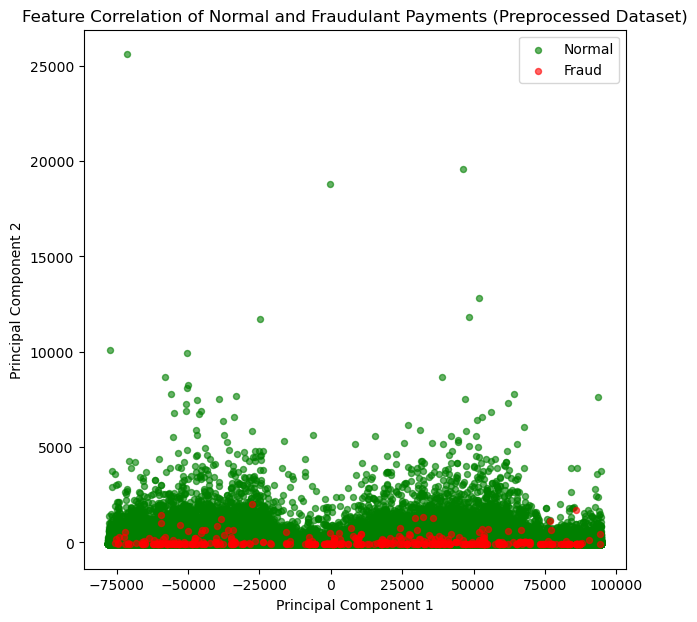

In [18]:
plotFeatureCorrelation(df, "Feature Correlation of Normal and Fraudulant Payments (Preprocessed Dataset)")

From above, we see a certain distinction between the normal and fraud records. While there is some correlation between the records (the bottom bit where the red and green dots overlap), a large number of the green (normal) records are towards the top. There is still noise but it is not as abundant as the distribution of the fraud records are not as broad as to cover the entire green spot.This is highly likely caused by the skewedness of the data (a lot more normal records than fraud). We can repeat the same steps above on the dataset after feature engineering to test this.
Also, note the large values of the Principal Components. This is due also to how unscaled certain features are, namely 'Time' and 'Amount'. The 'Time' column is increasing, and contributes little to no value to the rest of the features; the 'Amount' column is just unscaled.

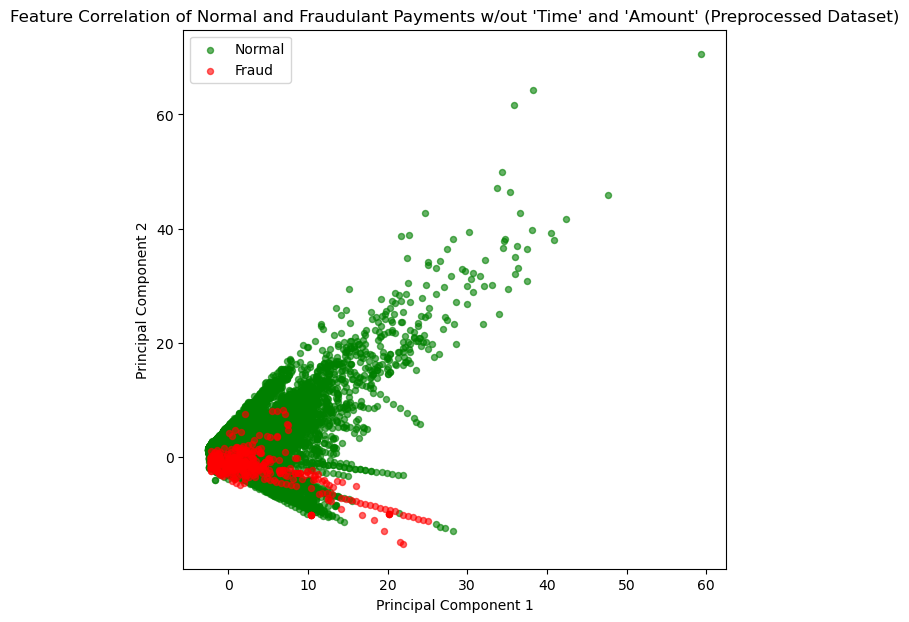

In [19]:
df_noTime = df.drop(columns=['Time', 'Amount'])
plotFeatureCorrelation(df_noTime, "Feature Correlation of Normal and Fraudulant Payments w/out 'Time' and 'Amount' (Preprocessed Dataset)")

#### Process 1: Removing Duplicates

As we can see, the dataset is heavily skewed, with a lot more Class = 0 than Class = 1 records. We can also see there are duplicate records within the dataset.

In [20]:
condition = df['Class'] == 0
#df = df[~(condition & df.duplicated())]
df = df.drop_duplicates()

In [21]:
false = df['Class'] == 0
true = df['Class'] == 1
false.sum(), true.sum()

(283253, 473)

In [22]:
df = df.reset_index()

#### Process 2: Scaling 'Amount' Column & Removing 'Time' and 'Amount' Columns (Normalization)

In [23]:
SS = StandardScaler()
df['normAmount'] = SS.fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time','Amount', 'index'], axis=1)
df #normalized

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244200
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342584
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.158900
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.139886
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283721,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.350252
283722,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.254325
283723,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.082239
283724,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.313391


!!!! note: now df is normalized. We will be working with this df from now on.

#### Checking new Feature Correlation after the steps above

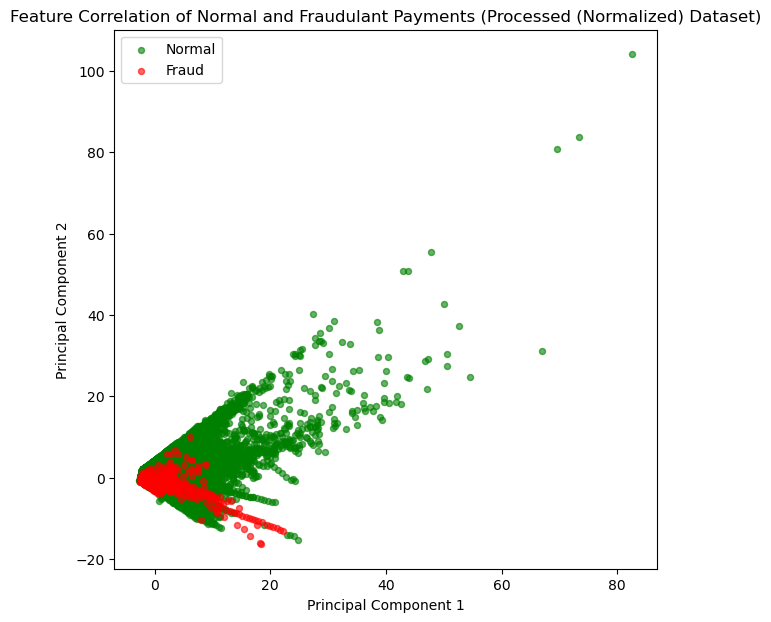

In [24]:
plotFeatureCorrelation(df, "Feature Correlation of Normal and Fraudulant Payments (Processed (Normalized) Dataset)")

Given the low but fair overlapping, the dataset should be resampled by undersampling the majority class to prevent overfitting.

### 1.3 Distribution of data through average values for each feature

Here I visualize the distribution of the feature values

In [25]:
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']

In [26]:
X.shape, y.shape

((283726, 29), (283726, 1))

In [27]:
#0 -> 27
avg = []
for i in range(0, 29): #start from 1 because index is included
    avg.append(X.iloc[:,i].mean())

In [28]:
labels = []
for i in range(1, 29):
    labels.append("V"+ str(i))
labels.append("normAmount")

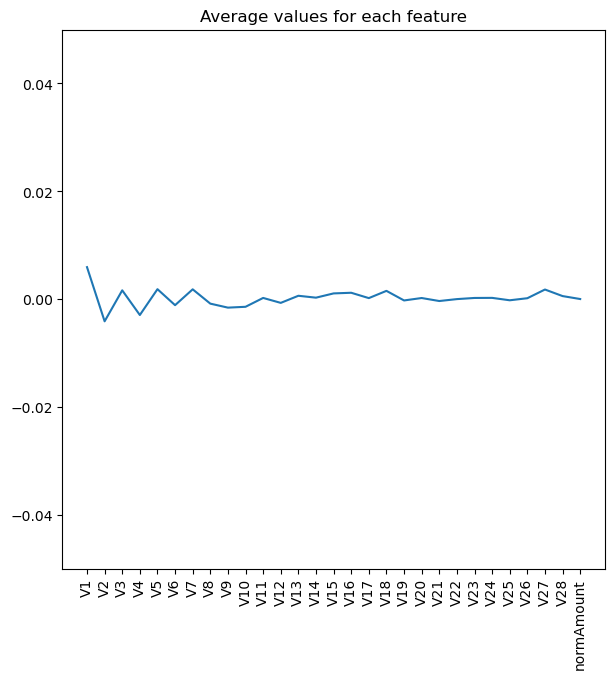

In [29]:
fig = plt.figure(figsize=(7,7), dpi=100)

plt.plot(avg)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylim(-0.05, 0.05) #scaled out appropriately to show flatness of line
plt.title("Average values for each feature")
plt.show()

Given that there is little variance, extra feature engineering, such as via feature enlargement, is not needed.

### 1.4 Feature Engineering

#### 1.4.1 Undersampling

In [30]:
num_fraud = len(df[df['Class'] == 1])

#selecting index of records that are fraud and normal
fraud_index = np.array(df[df['Class'] == 1].index) #1D
normal_index = np.array(df[df['Class'] == 0].index) #1D

#make num of fraud and normal the same (by randomly picking from normal, amount = num_fraud)
random_normal_index = np.random.choice(normal_index, num_fraud, replace = False) #randomly picks 'num_fraud' amounts so num_fraud = num_normal
random_normal_index = np.array(random_normal_index) #1D

#combine together, then forming the resampled dataframe
under_sample_indices = np.concatenate([fraud_index,random_normal_index])
under_sample_df = df.iloc[under_sample_indices,:] #all rows that correspond to these randomly chosen indexes

X_undersample = under_sample_df.iloc[:, under_sample_df.columns != 'Class']
y_undersample = under_sample_df.iloc[:, under_sample_df.columns == 'Class']

#### 1.4.2 Train-Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample,y_undersample,test_size = 0.3, random_state = 0)

#### 1.4.3 Probability Callibration

##### Undersampled

In [32]:
# Non anomaly ratio
num = (y_undersample.value_counts()[0]/len(y_undersample))
print("Ratio of Normal Records: ", num)
denom = (y_undersample.value_counts()[1]/len(y_undersample))
print("Ratio of Fraudulant Records: ",denom)
res = (num.item(0)/denom.item(0))
#res = (num.values[0]/denom.values[0])

sample_weight = np.array([res if i == 1 else 1 for i in y_undersample.values.ravel()])
undersample_res_array = sample_weight / len(sample_weight)
#print(res_array)

Ratio of Normal Records:  0.5
Ratio of Fraudulant Records:  0.5


In [33]:
X_train_undersample_calib, X_test_undersample_calib, y_train_undersample_calib, y_test_undersample_calib, sw_train, sw_test = train_test_split(X_undersample, y_undersample, undersample_res_array, test_size=0.3, random_state=0)

##### Original (Skewed)

In [34]:
num = (y.value_counts()[0]/len(y))
print("Ratio of Normal Records: ", num)
denom = (y.value_counts()[1]/len(y))
print("Ratio of Fraudulant Records: ",denom)
res = (num.item(0)/denom.item(0))

original_sample_weight = np.array([res if i == 1 else 1 for i in y.values.ravel()])
original_res_array = original_sample_weight / len(original_sample_weight)
print(original_res_array)

Ratio of Normal Records:  0.9983328986416472
Ratio of Fraudulant Records:  0.001667101358352777
[3.52452718e-06 3.52452718e-06 3.52452718e-06 ... 3.52452718e-06
 3.52452718e-06 3.52452718e-06]


In [35]:
X_train_calib, X_test_calib, y_train_calib, y_test_calib, sw_train_o, sw_test_o = train_test_split(X, y, original_res_array, test_size=0.3, random_state=0)

## 2. Models

### 2.1 SVM

#### 2.1.1 Stochastic Gradient Descent

Faster ML time than normal SVC

In [36]:
sgd_params = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
             'penalty':['l1','l2'],
             'alpha':[1e-1],
             'epsilon':[1e-5],
             'class_weight':['balanced'], #balance as res_array have same weight throughout
             'learning_rate':['invscaling'],
             'eta0':[1e-2]            
             } 

In [37]:
%%time

sgd_clf = SGDClassifier(random_state=0, fit_intercept=False,max_iter=20000)
sgd_cv = doGSCV(sgd_clf, sgd_params, 5, X_train_undersample, np.ravel(y_train_undersample))

Parameters used:  {'loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty': ['l1', 'l2'], 'alpha': [0.1], 'epsilon': [1e-05], 'class_weight': ['balanced'], 'learning_rate': ['invscaling'], 'eta0': [0.01]}
Best AUC score:  0.9783924414624128
Best parameters:  {'alpha': 0.1, 'class_weight': 'balanced', 'epsilon': 1e-05, 'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'log_loss', 'penalty': 'l2'}
Best cross-validated AUC score:  0.9725776710851338
!! -> Best estimator:  SGDClassifier(alpha=0.1, class_weight='balanced', epsilon=1e-05, eta0=0.01,
              fit_intercept=False, learning_rate='invscaling', loss='log_loss',
              max_iter=20000, random_state=0)
CPU times: total: 4.44 s
Wall time: 8.79 s


#### Probability Callibration

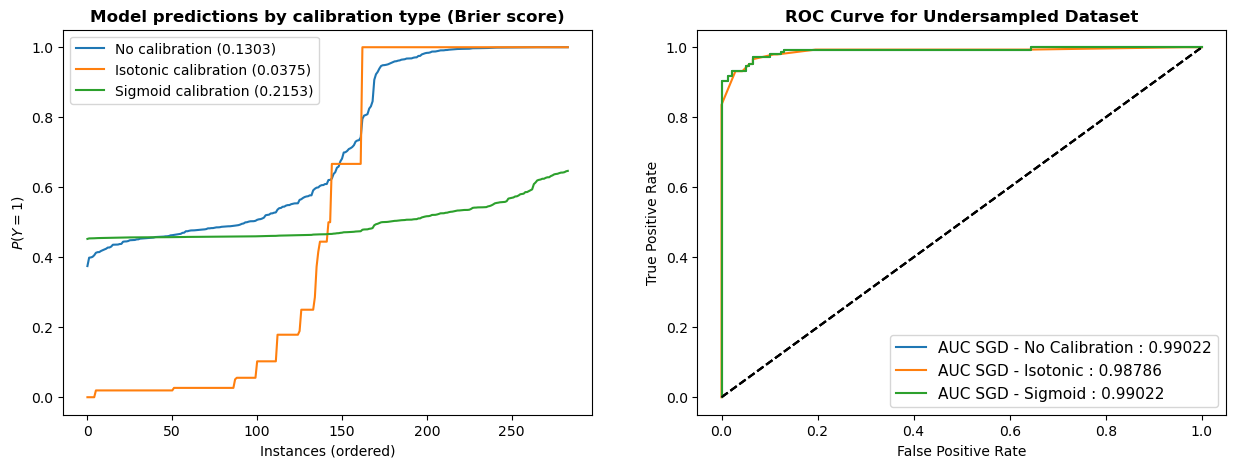

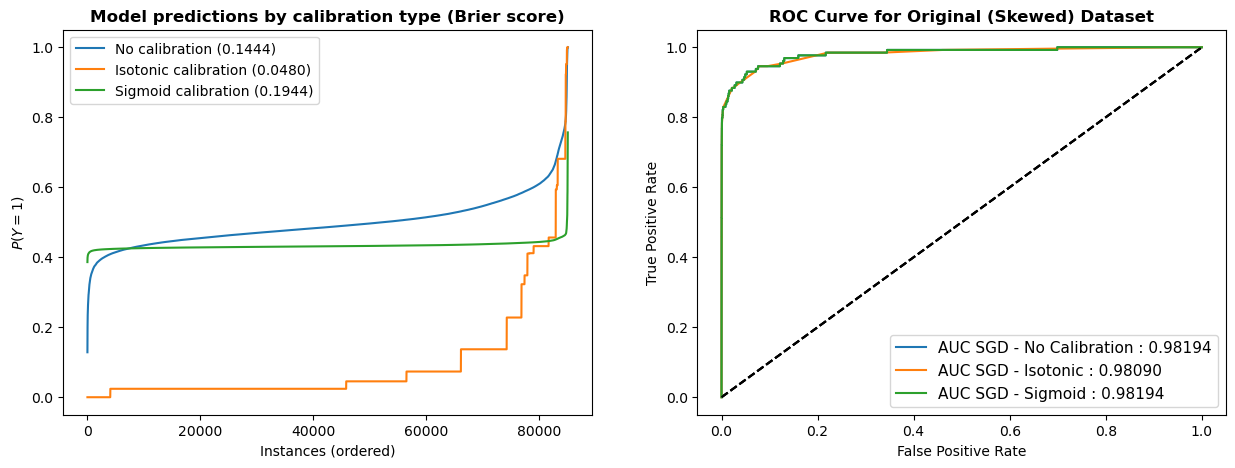

In [38]:
doProbCal(sgd_cv, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, "SGD", "Undersampled Dataset")
doProbCal(sgd_cv, X_train_calib, y_train_calib, X_test_calib, y_test_calib, sw_train_o, sw_test_o, "SGD", "Original (Skewed) Dataset")

#### Accuracy Score

In [39]:
print("Accuracy score for Original (Skewed) Dataset: ", accuracy_score(y_test, sgd_cv.predict(X_test)))

Accuracy score for Original (Skewed) Dataset:  0.6157921943654691


#### 2.1.2 Normal SVC

In [40]:
svc_params= {'kernel':['linear','poly','rbf','sigmoid'],
            'C': [0.01,0.1,1,5,10,20, 25,100,1000],
            'gamma':['scale','auto'],
            'probability': [True], #slow down, so I can use predict_proba
            'class_weight': ['balanced'],
            }

In [41]:
%%time
svc_clf = SVC(random_state=0)
svc_cv = doGSCV(svc_clf, svc_params, 5,X_train_undersample, np.ravel(y_train_undersample))

Parameters used:  {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': [0.01, 0.1, 1, 5, 10, 20, 25, 100, 1000], 'gamma': ['scale', 'auto'], 'probability': [True], 'class_weight': ['balanced']}
Best AUC score:  0.9887717376420647
Best parameters:  {'C': 5, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}
Best cross-validated AUC score:  0.9776376856973872
!! -> Best estimator:  SVC(C=5, class_weight='balanced', probability=True, random_state=0)
CPU times: total: 4min 46s
Wall time: 10min 3s


#### Probability Callibration

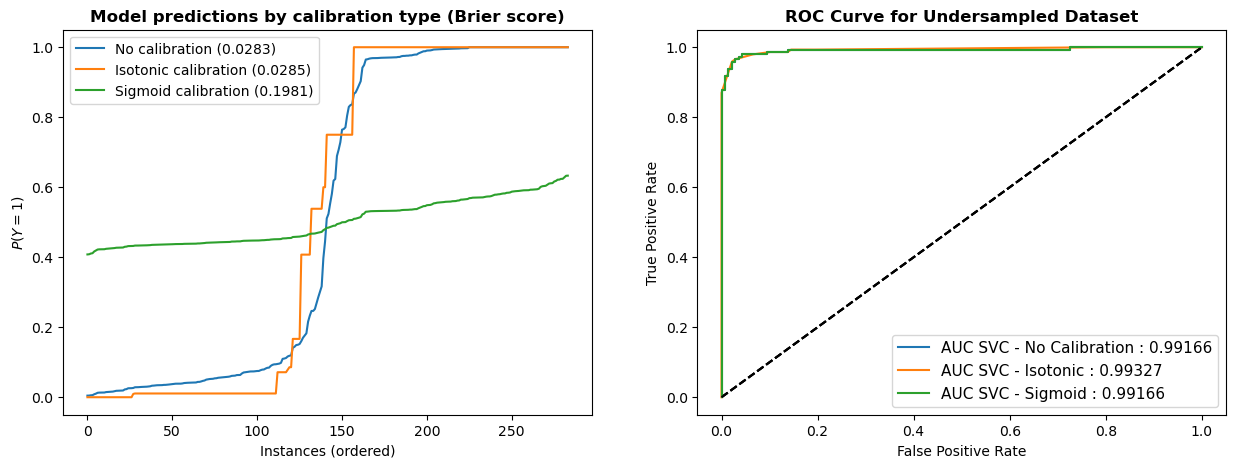

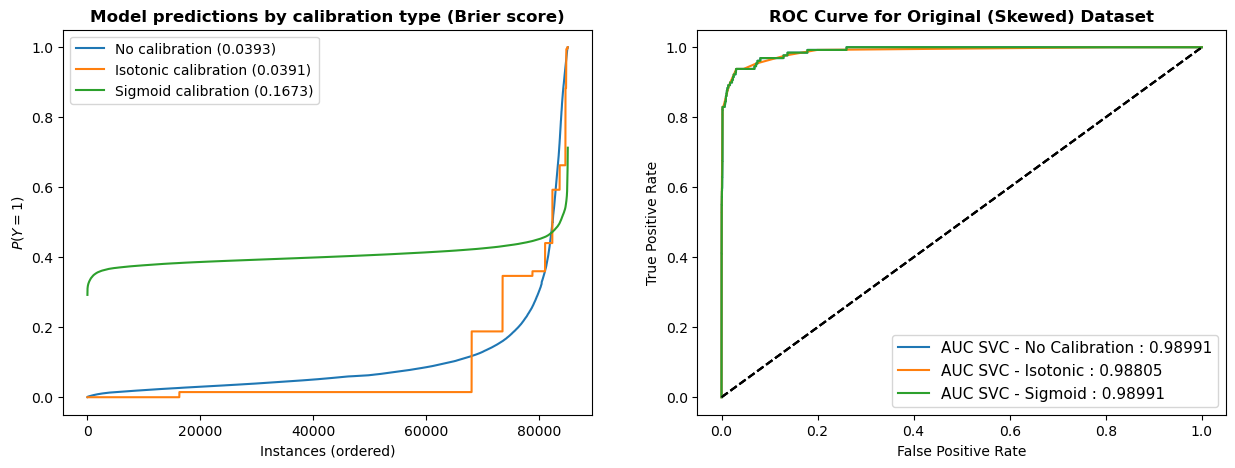

In [42]:
doProbCal(svc_cv, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, "SVC", "Undersampled Dataset")
doProbCal(svc_cv, X_train_calib, y_train_calib, X_test_calib, y_test_calib, sw_train_o, sw_test_o, "SVC", "Original (Skewed) Dataset")

#### Accuracy Score

In [43]:
print("Accuracy score for Original (Skewed) Dataset: ", accuracy_score(y_test, svc_cv.predict(X_test)))

Accuracy score for Original (Skewed) Dataset:  0.981731243685237


### 2.2 XGBoost

In [44]:
xgb_params ={'max_depth': [5],
        'learning_rate': [1e-1],
        'gamma':[0.3],
        'subsample':[0.9],
        'objective':['binary:logistic'],
        'eval_metric':['auc'],
        'scale_pos_weight':[9],
        'n_estimators':[60]}

In [45]:
%%time
xgb_clf = XGBClassifier(booster='gbtree')
xgb_cv = doGSCV(xgb_clf, xgb_params, RepeatedStratifiedKFold(n_splits=3),X_train_undersample, np.ravel(y_train_undersample))

Parameters used:  {'max_depth': [5], 'learning_rate': [0.1], 'gamma': [0.3], 'subsample': [0.9], 'objective': ['binary:logistic'], 'eval_metric': ['auc'], 'scale_pos_weight': [9], 'n_estimators': [60]}
Best AUC score:  1.0
Best parameters:  {'eval_metric': 'auc', 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60, 'objective': 'binary:logistic', 'scale_pos_weight': 9, 'subsample': 0.9}
Best cross-validated AUC score:  0.9778163730571989
!! -> Best estimator:  XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.3, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=

#### Probability Callibration

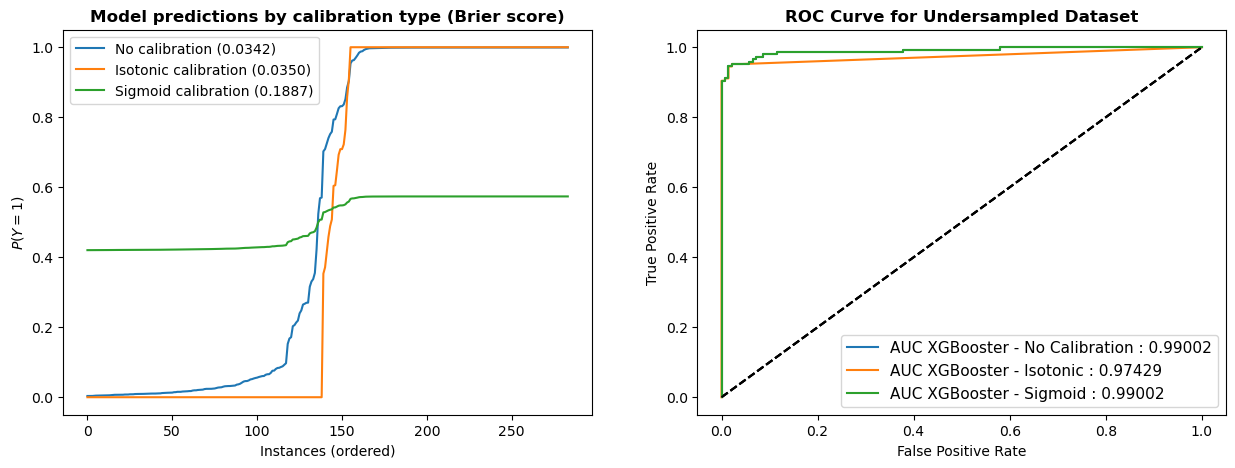

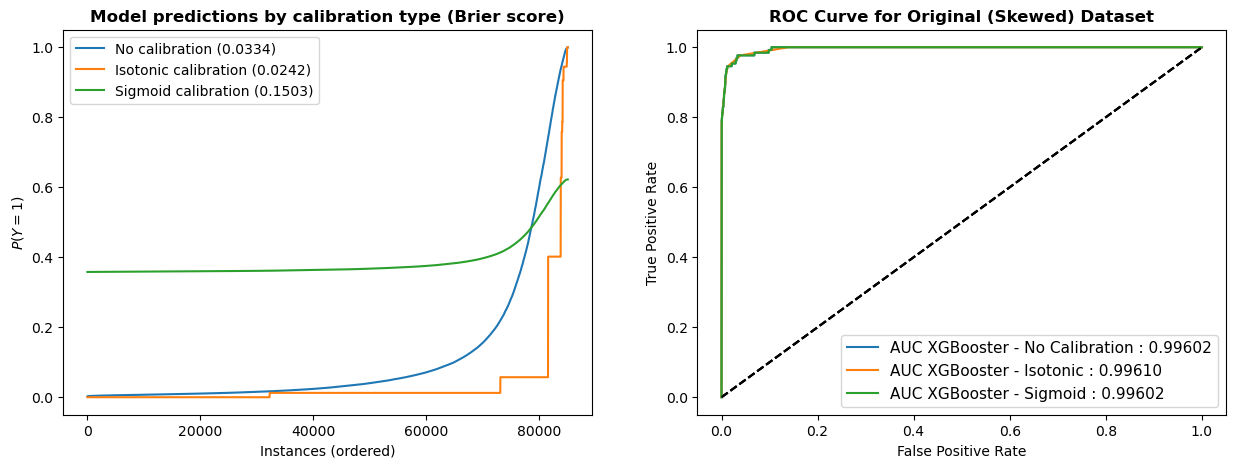

In [46]:
doProbCal(xgb_cv, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, "XGBooster", "Undersampled Dataset")
doProbCal(xgb_cv, X_train_calib, y_train_calib, X_test_calib, y_test_calib, sw_train_o, sw_test_o, "XGBooster", "Original (Skewed) Dataset")

#### Accuracy Score

In [47]:
print("Accuracy score for Original (Skewed) Dataset: ", accuracy_score(y_test, xgb_cv.predict(X_test)))

Accuracy score for Original (Skewed) Dataset:  0.9280058272045866


### 2.3 LightGBM

In [48]:
lgbm_params = {'learning_rate':[5e-2],
        'max_depth': [4],
        'reg_alpha':[1e-1],
        'reg_lambda':[1e-3],
        #'gamma':[0.3], #removed by Shang 01/05/2024
        'subsample':[0.9],
        'objective':['binary'],
        #'eval_metric':['auc'],#removed by Shang 01/05/2024
        'scale_pos_weight':[1]}

In [49]:
%%time
lgbm_clf = LGBMClassifier(n_estimators=50, random_state=0,verbose=-1)
lgbm_cv = doGSCV(lgbm_clf, lgbm_params, RepeatedStratifiedKFold(n_splits=3, random_state=0),X_train_undersample, np.ravel(y_train_undersample))

Parameters used:  {'learning_rate': [0.05], 'max_depth': [4], 'reg_alpha': [0.1], 'reg_lambda': [0.001], 'subsample': [0.9], 'objective': ['binary'], 'scale_pos_weight': [1]}
Best AUC score:  0.9972522707563102
Best parameters:  {'learning_rate': 0.05, 'max_depth': 4, 'objective': 'binary', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'scale_pos_weight': 1, 'subsample': 0.9}
Best cross-validated AUC score:  0.975299574640171
!! -> Best estimator:  LGBMClassifier(learning_rate=0.05, max_depth=4, n_estimators=50,
               objective='binary', random_state=0, reg_alpha=0.1,
               reg_lambda=0.001, scale_pos_weight=1, subsample=0.9, verbose=-1)
CPU times: total: 2.86 s
Wall time: 4.28 s


#### Probability Callibration

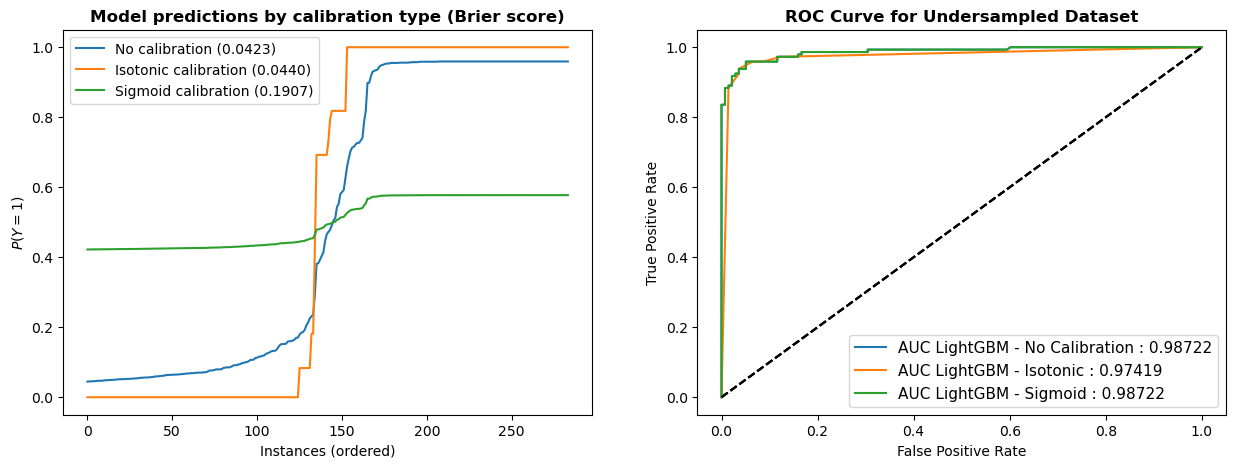

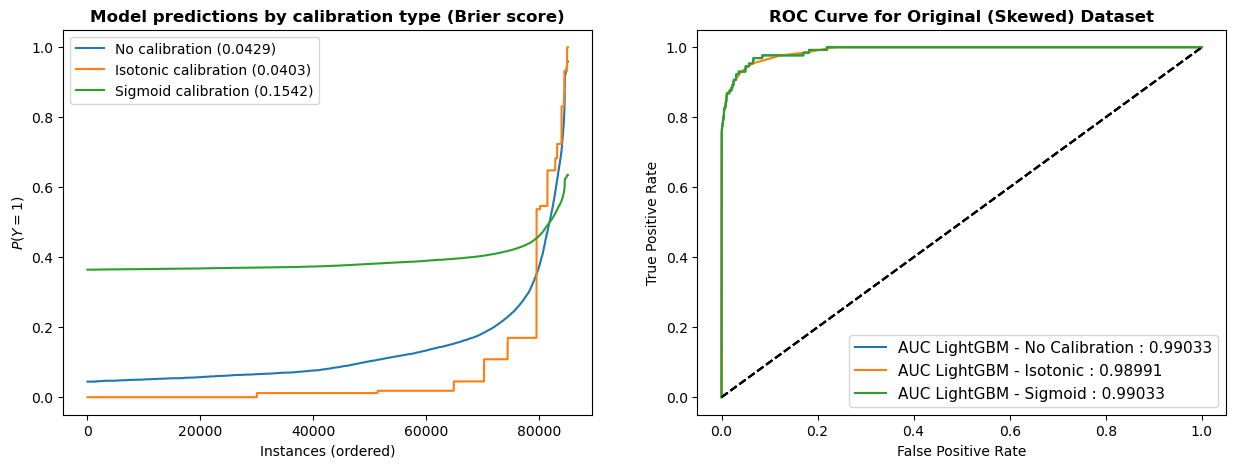

In [50]:
doProbCal(lgbm_cv, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, "LightGBM", "Undersampled Dataset")
doProbCal(lgbm_cv, X_train_calib, y_train_calib, X_test_calib, y_test_calib, sw_train_o, sw_test_o, "LightGBM", "Original (Skewed) Dataset")

#### Accuracy Score

In [51]:
print("Accuracy score for Original (Skewed) Dataset: ", accuracy_score(y_test, lgbm_cv.predict(X_test)))

Accuracy score for Original (Skewed) Dataset:  0.9632862614253155


### 2.4 CatBoost

In [52]:
cb_params ={'learning_rate':[5e-2],
        'max_depth': [4],
        'reg_lambda':[1],
        'bootstrap_type': ['Bernoulli'],
        'subsample':[0.95],
        'eval_metric':['AUC'],
        'scale_pos_weight':[15],
        'logging_level':['Silent']}

In [53]:
%%time
cb_clf = CatBoostClassifier(n_estimators=60, random_state=0)
cb_cv = doGSCV(cb_clf, cb_params, RepeatedStratifiedKFold(n_splits=3, random_state=0),X_train_undersample, np.ravel(y_train_undersample))

Parameters used:  {'learning_rate': [0.05], 'max_depth': [4], 'reg_lambda': [1], 'bootstrap_type': ['Bernoulli'], 'subsample': [0.95], 'eval_metric': ['AUC'], 'scale_pos_weight': [15], 'logging_level': ['Silent']}
Best AUC score:  0.9962207312063536
Best parameters:  {'bootstrap_type': 'Bernoulli', 'eval_metric': 'AUC', 'learning_rate': 0.05, 'logging_level': 'Silent', 'max_depth': 4, 'reg_lambda': 1, 'scale_pos_weight': 15, 'subsample': 0.95}
Best cross-validated AUC score:  0.9736464839675848
!! -> Best estimator:  <catboost.core.CatBoostClassifier object at 0x0000024FE7CB5310>
CPU times: total: 10.2 s
Wall time: 16.1 s


#### Probability Callibration

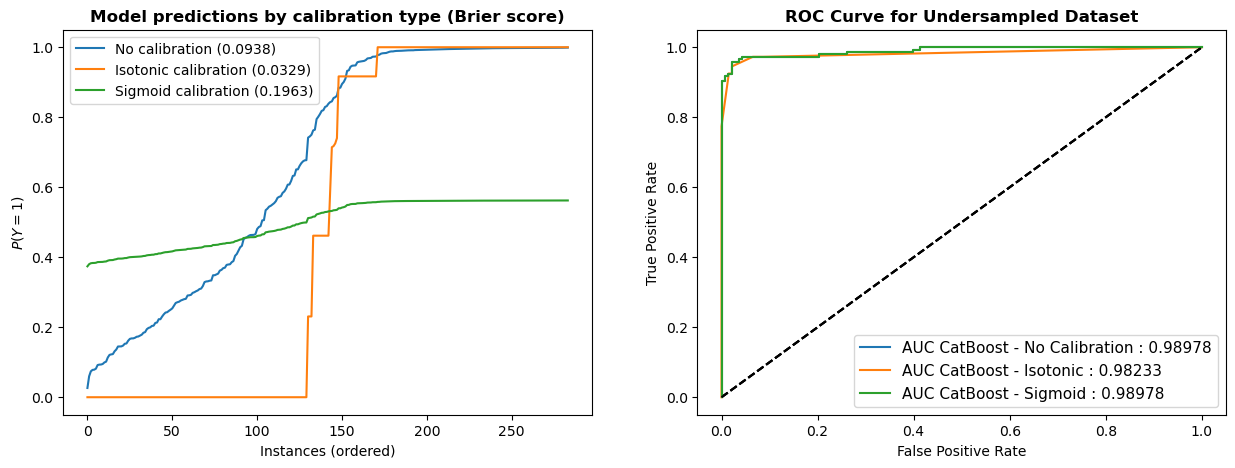

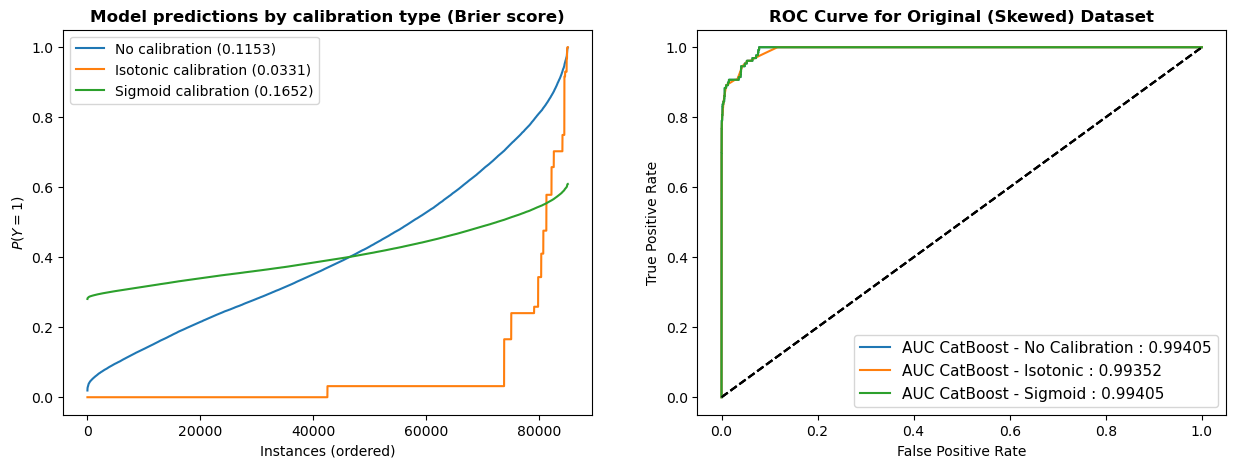

In [54]:
doProbCal(cb_cv, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, "CatBoost", "Undersampled Dataset")
doProbCal(cb_cv, X_train_calib, y_train_calib, X_test_calib, y_test_calib, sw_train_o, sw_test_o, "CatBoost", "Original (Skewed) Dataset")

In [55]:
print("Accuracy score for Original (Skewed) Dataset: ", accuracy_score(y_test, cb_cv.predict(X_test)))

Accuracy score for Original (Skewed) Dataset:  0.6750158603350642


### 2.5 Random Forest

In [56]:
rf_params = {'n_estimators': [5, 10, 20, 50], 'min_samples_split': [2, 10, 50, 100, 200, 500]}

In [57]:
%%time
rf_clf = RandomForestClassifier(random_state=99)
rf_cv = doGSCV(rf_clf, rf_params, RepeatedStratifiedKFold(n_splits=3, random_state=0),X_train_undersample, np.ravel(y_train_undersample))

Parameters used:  {'n_estimators': [5, 10, 20, 50], 'min_samples_split': [2, 10, 50, 100, 200, 500]}
Best AUC score:  1.0
Best parameters:  {'min_samples_split': 2, 'n_estimators': 50}
Best cross-validated AUC score:  0.9735479540812111
!! -> Best estimator:  RandomForestClassifier(n_estimators=50, random_state=99)
CPU times: total: 44.8 s
Wall time: 1min 40s


#### Probability Callibration

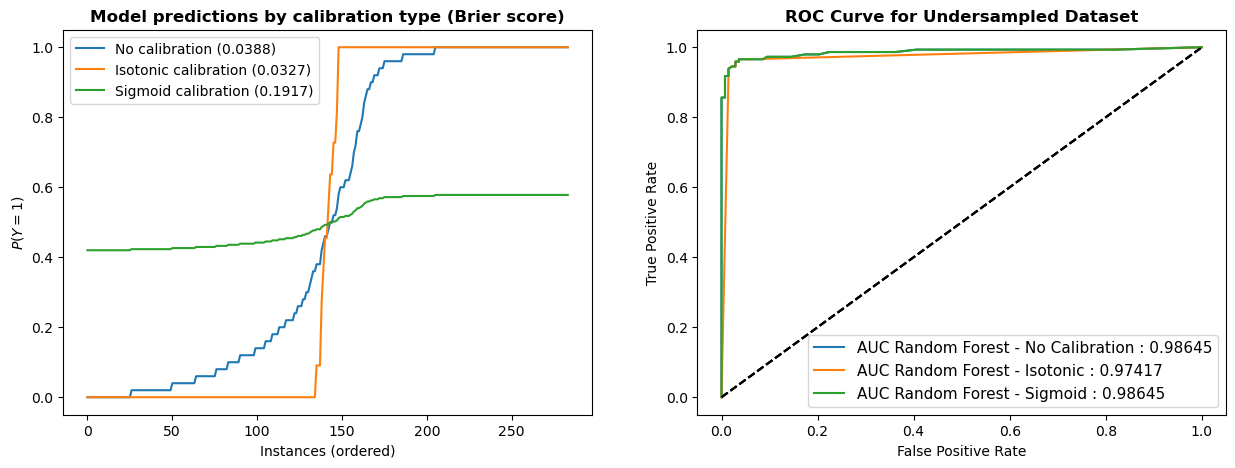

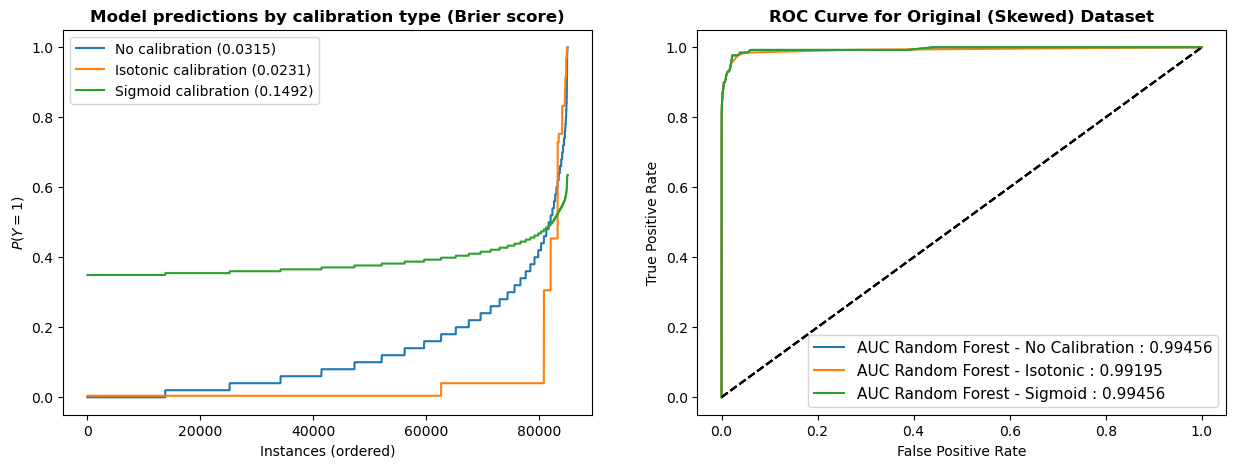

In [58]:
doProbCal(rf_cv, X_train_undersample_calib, y_train_undersample_calib, X_test_undersample_calib, y_test_undersample_calib, sw_train, sw_test, "Random Forest", "Undersampled Dataset")
doProbCal(rf_cv, X_train_calib, y_train_calib, X_test_calib, y_test_calib, sw_train_o, sw_test_o, "Random Forest", "Original (Skewed) Dataset")

#### Accuracy Score

In [59]:
print("Accuracy score for Original (Skewed) Dataset: ", accuracy_score(y_test, rf_cv.predict(X_test)))

Accuracy score for Original (Skewed) Dataset:  0.9656359406940953


## 3. Stacking

After evaluating the above models, I found that XGBooster performed the best based on the AUC metric. This is why the stacking method utilizes as the final learning model the XGBClassifier.

In [1]:
#adapted from Simon, D (2021). Data Challenge - Machine Learning for anomaly detection [Python Code]. Github. https://github.com/simondelarue/Data-Challenge_Anomaly-Detection 

In [60]:
%%time

def get_stacking():
    ''' Define stacking strategy '''
    
    # Base models
    level0 = list()
    level0.append(('XGB', xgb_cv))
    
    #params eval_metric and gamma were removed by Shang 01/05/2023. eval_metric='auc', gamma=0.3, 
    #level0.append(('LGBM', LGBMClassifier(eval_metric='auc', gamma=0.3, learning_rate=5e-2, max_depth=5, objective='binary', \
    #                                         reg_alpha=1e-1, reg_lambda=1e-3, scale_pos_weight=1)))
    
    level0.append(('LGBM', lgbm_cv))
    
    level0.append(('RandomF', rf_cv))

    # Learner model
    level1 = XGBClassifier(learning_rate=0.1)
    
    # Stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=3)
    
    return model

def get_models():
    #Get list of models to evaluate 
    
    models = dict()
    models['XGB'] = xgb_cv
    
    #params eval_metric and gamma were removed by Shang 01/05/2024
    #models['LGBM'] = LGBMClassifier(eval_metric='auc', gamma=0.3, learning_rate=5e-2, max_depth=5, objective='binary', \
    #                                         reg_alpha=1e-1, reg_lambda=1e-3, scale_pos_weight=1)
    
    models['LGBM'] = lgbm_cv
    models['RandomF'] = rf_cv
    models['stacking'] = get_stacking()
    
    return models

def evaluate_model(model, X, y):
    # Evalue model (using cross-val)'''
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv)
    
    return scores

X, y = X_train, np.ravel(y_train)
models = get_models()
results, names = list(), list()

for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('AUC Scores \n----------------------------')
    print(f'{name} : {np.mean(scores):.5f}  ({np.std(scores):.5f})')

AUC Scores 
----------------------------
XGB : 0.97542  (0.00431)
AUC Scores 
----------------------------
LGBM : 0.90696  (0.06981)
AUC Scores 
----------------------------
RandomF : 0.93637  (0.01107)
AUC Scores 
----------------------------
stacking : 0.96214  (0.01221)
CPU times: total: 50min 3s
Wall time: 1h 13min 36s


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Model": [
        "XGBoost", "LightBGM", "RandomForest", "CatBoost", 
        "kNN", "Logistic Regression", "Ridge Regression", "SVC", "SGD"
    ],
    "Feature_Extraction": [161.222, 168.309, 155.296, 157.490, 168.130, 158.618, 167.754, 182.724, 158.027],
    "Scaling": [None, None, None, None, 12.388, 12.944, 12.586, 13.108, 11.757]
}

df = pd.DataFrame(data)
df["Scaling"] = df["Scaling"].apply(lambda x: x if x is not None else float('nan'))

# Feature Extraction box plot
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(df["Feature_Extraction"].dropna(), vert=True, patch_artist=True)
ax.set_xticks([1])
ax.set_xticklabels(["Feature Extraction"])
ax.set_ylabel("Time (ms)")
ax.set_title("Feature Extraction Times Across Models")
ax.grid(axis='y')

# Save figure
fig.savefig("feature_extraction_times.pdf", format='pdf')
plt.close(fig)  # Close figure to free memory

# Scaling box plot
fig, ax = plt.subplots(figsize=(6,6))
ax.boxplot(df["Scaling"].dropna(), vert=True, patch_artist=True)
ax.set_xticks([1])
ax.set_xticklabels(["Scaling"])
ax.set_ylabel("Time (ms)")
ax.set_title("Scaling Times Across Models")
ax.grid(axis='y')

# Save figure
fig.savefig("scaling_times.pdf", format='pdf')
plt.close(fig)

In [ ]:
# Box plot of Scaling times (only models that use scaling)
plt.figure(figsize=(5,5))
plt.boxplot(df["Scaling"].dropna(), vert=True, patch_artist=True)
plt.xticks([1], ["Scaling"])
plt.ylabel("Time (ms)")
plt.title("Scaling Times Across Models")
plt.grid(axis='y')
plt.show()

plt.savefig("scal_avg.pdf", format='pdf')

In [ ]:
    # Confidence over time
    running_confidence = []
    
    for i in range(len(y_pred)):
        val = y_pred[i]
        count_so_far = np.sum(y_pred[:i+1] == val)
        ratio = count_so_far / (i+1)
        running_confidence.append(ratio)
        print(f"Index {i}: Label = {val}, Confidence = {ratio:.2f}")

    labels = np.unique(y_pred)

    # Compute running confidence for each label
    running_conf = {label: [] for label in labels}
    
    for i in range(len(y_pred)):
        for label in labels:
            ratio = np.sum(y_pred[:i+1] == label) / (i+1)
            running_conf[label].append(ratio)